Largest Lyapunov exponent: 0.215434720283641


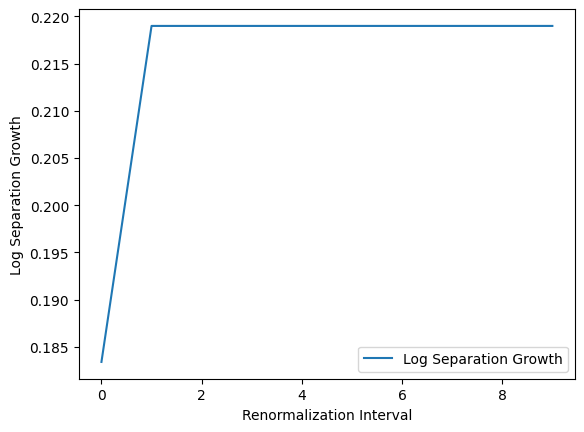

In [3]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Gravitational constant (normalized units)
G = 1

def three_body_eq(t, y, params):
    G, m1, m2, m3 = params
    x1, y1, x2, y2, x3, y3 = y[0:6]
    vx1, vy1, vx2, vy2, vx3, vy3 = y[6:12]
    r12 = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    r13 = np.sqrt((x3 - x1)**2 + (y3 - y1)**2)
    r23 = np.sqrt((x3 - x2)**2 + (y3 - y2)**2)
    
    ax1 = G * m2 * (x2 - x1) / r12**3 + G * m3 * (x3 - x1) / r13**3
    ay1 = G * m2 * (y2 - y1) / r12**3 + G * m3 * (y3 - y1) / r13**3
    
    ax2 = G * m1 * (x1 - x2) / r12**3 + G * m3 * (x3 - x2) / r23**3
    ay2 = G * m1 * (y1 - y2) / r12**3 + G * m3 * (y3 - y2) / r23**3
    
    ax3 = G * m1 * (x1 - x3) / r13**3 + G * m2 * (x2 - x3) / r23**3
    ay3 = G * m1 * (y1 - y3) / r13**3 + G * m2 * (y2 - y3) / r23**3
    
    return np.array([vx1, vy1, vx2, vy2, vx3, vy3, ax1, ay1, ax2, ay2, ax3, ay3])

# Initial conditions and parameters
masses = (G, 1.0, 1.0, 1.0)  # Include G in parameters
p1 = 0.347111
p2 = 0.532728
y0 = np.array([-1, 0, 1, 0, 0, 0,
               p1, p2, p1, p2, -2 * p1, 2 * p2])

# Integration parameters
t_span = (0, 150)  # Shorter interval for each renormalization
t_eval = np.linspace(*t_span, 100)

# Define a small initial perturbation and norm size
perturbation = 1e-12
num_renormalizations = 10  # How often we reset the perturbation to avoid growth limit

# Initialize arrays to store separation growth
initial_perturbation = np.random.normal(scale=perturbation, size=6)  # Position perturbation
perturbed_y0 = np.concatenate([y0[:6] + initial_perturbation, y0[6:]])  # Position only

# Storage for Lyapunov exponent values
lyapunov_exponent_values = []

# Iterate for renormalizations
for i in range(num_renormalizations):
    # Integrate unperturbed and perturbed system for one interval
    sol_unperturbed = solve_ivp(three_body_eq, t_span, y0, args=(masses,), t_eval=t_eval, rtol=1e-10)
    sol_perturbed = solve_ivp(three_body_eq, t_span, perturbed_y0, args=(masses,), t_eval=t_eval, rtol=1e-10)
    
    # Calculate the separation at the end of the interval
    delta = sol_perturbed.y[:6, -1] - sol_unperturbed.y[:6, -1]
    final_separation = np.linalg.norm(delta)
    lyapunov_exponent_values.append(np.log(final_separation / perturbation) / (t_span[1] - t_span[0]))

    # Renormalize the separation
    delta_normalized = perturbation * delta / np.linalg.norm(delta)
    perturbed_y0 = np.concatenate([sol_unperturbed.y[:6, -1] + delta_normalized, sol_unperturbed.y[6:, -1]])

# Average Lyapunov exponent over intervals
lyapunov_exponent = np.mean(lyapunov_exponent_values)
print(f"Largest Lyapunov exponent: {lyapunov_exponent}")

# Plot the log separation over intervals
plt.plot(np.arange(num_renormalizations), lyapunov_exponent_values, label="Log Separation Growth")
plt.xlabel("Renormalization Interval")
plt.ylabel("Log Separation Growth")
plt.legend()
plt.show()

In [4]:
print(lyapunov_exponent_values)

[0.18341285173228117, 0.21899268495357085, 0.2189927083200694, 0.21899270826149836, 0.21899270826149836, 0.21899270826149836, 0.21899270826149836, 0.21899270826149836, 0.21899270826149836, 0.21899270826149836]


In [ ]:
def total_energy(y, masses):
    G, m1, m2, m3 = masses
    x1, y1, x2, y2, x3, y3 = y[:6]
    vx1, vy1, vx2, vy2, vx3, vy3 = y[6:12]
    
    r12 = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    r13 = np.sqrt((x3 - x1)**2 + (y3 - y1)**2)
    r23 = np.sqrt((x3 - x2)**2 + (y3 - y2)**2)
    
    kinetic = 0.5 * m1 * (vx1**2 + vy1**2) + 0.5 * m2 * (vx2**2 + vy2**2) + 0.5 * m3 * (vx3**2 + vy3**2)
    potential = -G * m1 * m2 / r12 - G * m1 * m3 / r13 - G * m2 * m3 / r23
    return kinetic + potential

# Compute total energy over time
energies = [total_energy(y0, masses) for y in sol_unperturbed.y.T]
plt.plot(t_eval, energies, label="Total Energy")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()
plt.show()


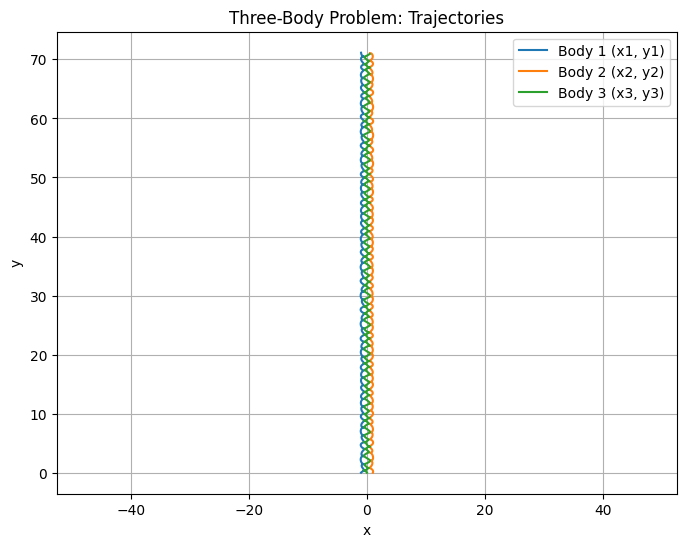

In [12]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Gravitational constant (normalized units)
G = 1

def three_body_eq(t, y, params):
    G, m1, m2, m3 = params
    x1, y1, x2, y2, x3, y3 = y[0:6]
    vx1, vy1, vx2, vy2, vx3, vy3 = y[6:12]
    r12 = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    r13 = np.sqrt((x3 - x1)**2 + (y3 - y1)**2)
    r23 = np.sqrt((x3 - x2)**2 + (y3 - y2)**2)
    
    ax1 = G * m2 * (x2 - x1) / r12**3 + G * m3 * (x3 - x1) / r13**3
    ay1 = G * m2 * (y2 - y1) / r12**3 + G * m3 * (y3 - y1) / r13**3
    
    ax2 = G * m1 * (x1 - x2) / r12**3 + G * m3 * (x3 - x2) / r23**3
    ay2 = G * m1 * (y1 - y2) / r12**3 + G * m3 * (y3 - y2) / r23**3
    
    ax3 = G * m1 * (x1 - x3) / r13**3 + G * m2 * (x2 - x3) / r23**3
    ay3 = G * m1 * (y1 - y3) / r13**3 + G * m2 * (y2 - y3) / r23**3
    
    return np.array([vx1, vy1, vx2, vy2, vx3, vy3, ax1, ay1, ax2, ay2, ax3, ay3])

# Initial conditions and parameters
masses = (G, 1.0, 1.0, 1.0)  # Include G in parameters
p1 = 0.347111
p2 = 0.532728
y0 = np.array([-1, 0, 1, 0, 0, 0,
               p1, p2, p1, p2, -2 * p1, 2 * p2])

# Integration parameters
t_span = (0, 100)  # Total simulation time
t_eval = np.linspace(*t_span, 1000)

# Integrate the system
sol = solve_ivp(three_body_eq, t_span, y0, args=(masses,), t_eval=t_eval, rtol=1e-9)

# Plot the trajectories of the three bodies
plt.figure(figsize=(8, 6))
plt.plot(sol.y[0], sol.y[1], label="Body 1 (x1, y1)")
plt.plot(sol.y[2], sol.y[3], label="Body 2 (x2, y2)")
plt.plot(sol.y[4], sol.y[5], label="Body 3 (x3, y3)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Three-Body Problem: Trajectories")
plt.legend()
plt.grid()
plt.axis("equal")
plt.show()


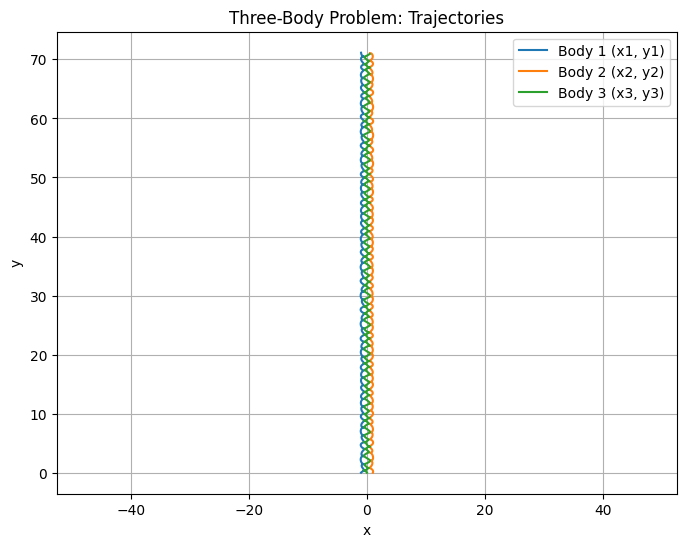

In [11]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Gravitational constant (normalized units)
G = 1

def three_body_eq(t, y, params):
    G, m1, m2, m3 = params
    x1, y1, x2, y2, x3, y3 = y[0:6]
    vx1, vy1, vx2, vy2, vx3, vy3 = y[6:12]
    r12 = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    r13 = np.sqrt((x3 - x1)**2 + (y3 - y1)**2)
    r23 = np.sqrt((x3 - x2)**2 + (y3 - y2)**2)
    
    ax1 = G * m2 * (x2 - x1) / r12**3 + G * m3 * (x3 - x1) / r13**3
    ay1 = G * m2 * (y2 - y1) / r12**3 + G * m3 * (y3 - y1) / r13**3
    
    ax2 = G * m1 * (x1 - x2) / r12**3 + G * m3 * (x3 - x2) / r23**3
    ay2 = G * m1 * (y1 - y2) / r12**3 + G * m3 * (y3 - y2) / r23**3
    
    ax3 = G * m1 * (x1 - x3) / r13**3 + G * m2 * (x2 - x3) / r23**3
    ay3 = G * m1 * (y1 - y3) / r13**3 + G * m2 * (y2 - y3) / r23**3
    
    return np.array([vx1, vy1, vx2, vy2, vx3, vy3, ax1, ay1, ax2, ay2, ax3, ay3])

# Initial conditions and parameters
masses = (G, 1.0, 1.0, 1.0)  # Include G in parameters
p1 = 0.347111
p2 = 0.532728
y0 = np.array([-1, 0, 1, 0, 0, 0,
               p1, p2, p1, p2, -2 * p1, 2 * p2])

# Integration parameters
t_span = (0, 100)  # Total simulation time
t_eval = np.linspace(*t_span, 1000)

# Integrate the system
sol = solve_ivp(three_body_eq, t_span, y0, args=(masses,), t_eval=t_eval, rtol=1e-9)

# Plot the trajectories of the three bodies
plt.figure(figsize=(8, 6))
plt.plot(sol.y[0], sol.y[1], label="Body 1 (x1, y1)")
plt.plot(sol.y[2], sol.y[3], label="Body 2 (x2, y2)")
plt.plot(sol.y[4], sol.y[5], label="Body 3 (x3, y3)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Three-Body Problem: Trajectories")
plt.legend()
plt.grid()
plt.axis("equal")
plt.show()
